In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import cv2
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from skimage.metrics import structural_similarity as ssim

1. Получить данные.  
2. Реализовать три модели кластеризации:  
    a. `KMeans`. Рассмотрите число кластеров K = 2, 5, 10, 20.  
    b. `DBSCAN`  
    c. `AgglomerativeClustering`. Рассмотреть число кластеров K = 2, 5, 10, 20.  
3. Для каждой модели оценить потери от уменьшения цветов при помощи метрики `SSIM`.
4. Сформулировать выводы.  

#### 1. Загружаем картинку

In [2]:
path = './data/птица.jpeg'

In [3]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title, fontsize=8)

In [4]:
img = cv2.imread(path)
img = cv2.resize(img, (220, 220)) # сразу же сжимаем картинку, иначе процессор повиснет!!!!

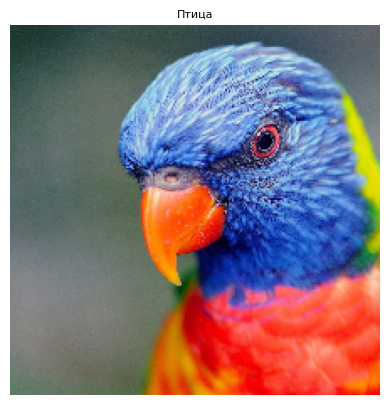

In [5]:
draw_picture(img, 'Птица', bgr=False)

In [6]:
img.shape

(220, 220, 3)

In [7]:
img

array([[[ 57,  64,  37],
        [ 55,  63,  36],
        [ 52,  59,  32],
        ...,
        [109, 102,  99],
        [111, 104, 101],
        [106,  99,  96]],

       [[ 54,  61,  34],
        [ 51,  58,  31],
        [ 57,  64,  37],
        ...,
        [104,  99,  96],
        [105, 100,  97],
        [105, 100,  97]],

       [[ 60,  67,  39],
        [ 54,  61,  34],
        [ 57,  64,  37],
        ...,
        [102,  97,  94],
        [103,  98,  95],
        [108, 102,  99]],

       ...,

       [[105, 124,  91],
        [109, 127,  96],
        [108, 126,  95],
        ...,
        [  4,  28, 249],
        [  5,  26, 252],
        [  4,  20, 251]],

       [[107, 126,  93],
        [104, 123,  90],
        [106, 124,  93],
        ...,
        [  3,  11, 250],
        [  5,  12, 253],
        [  5,  12, 253]],

       [[103, 126,  88],
        [108, 128,  93],
        [106, 125,  92],
        ...,
        [  4,   3, 253],
        [  4,   4, 252],
        [  1,   3, 251]]

Объект `img` это 3D матрица где измерения это высота, ширина и количество каналов цвета. Преобразуем ее в двухмерную, где канал будет определен для каждого пикселя

In [8]:
X = img.reshape(img.shape[0] * img.shape[1], 3)
X

array([[ 57,  64,  37],
       [ 55,  63,  36],
       [ 52,  59,  32],
       ...,
       [  4,   3, 253],
       [  4,   4, 252],
       [  1,   3, 251]], dtype=uint8)

In [9]:
X.shape

(48400, 3)

#### 2. Реализация моделей кластеризации

Далее для уменьшения количества цветов соберем функцию где:  
1. Изменим размерность исходного изображения
2. Создадим объект модели в указанием параметра количества кластеров (для DBSCAN кластера не выбираются - этот объект будет создаваться в отдельной ветке
3. Если какой-то параметр будет приводить к ошибке выведем оригинальную матрицу
4. Получим вектор с кластерами
5. Преобразуем 2D матрицу в пандасовский  датафрейм
6. Добавим вектор с кластерами к датафрейму
7. Создадим словарь где ключи это идентификаторы кластеров, а значения средние значения трех каналов
8. Заменим каждую строку в 2D матрице на полученные усредненные значения канала в соответствии с кластером
9. Преобразуем 2D матрицу снова в 3D
10. Рассчитаем метрику SSIM и отрисуем изображение

In [10]:
def get_image(img, model, n_clusters=2):
    X = img.reshape(img.shape[0] * img.shape[1], 3)
    try:
        if model == DBSCAN:
            m = DBSCAN(eps=4, min_samples=2)
        else:
            m = model(n_clusters=n_clusters)        
        cluster = m.fit_predict(X)
        df = pd.DataFrame(X)
        df['cluster'] = cluster

        cluster_dict = {c: df.loc[df['cluster'] == c, [0, 1, 2]].mean(axis=0) for c in set(cluster)}

        X_mod = [cluster_dict[c] for c in cluster]
        X_mod = np.array(X_mod, dtype=np.uint8)
        img_mod = X_mod.reshape(img.shape[0], img.shape[1], 3)
        ssim_score = ssim(img, img_mod, channel_axis=2 )
        title = f'{m}\nssim: {ssim_score:.3f}'
    except:
        img_mod = img
        ssim_score = ssim(img, img_mod, channel_axis=2 )
        title = f'Original\nssim: {ssim_score:.3f}'
    return draw_picture(img_mod, title)

In [11]:
K = [None, 2, 5, 10, 20] # кол-во кластеров. None выдаст ошибку, ветка перейдет в except и график выведет оригинал картинки

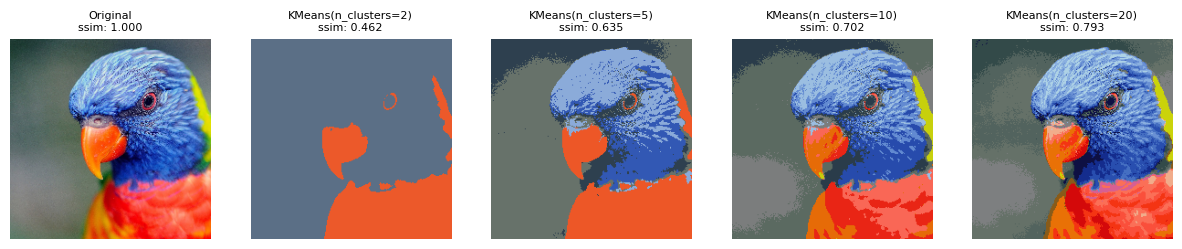

KMeans длительность 2.11 сек


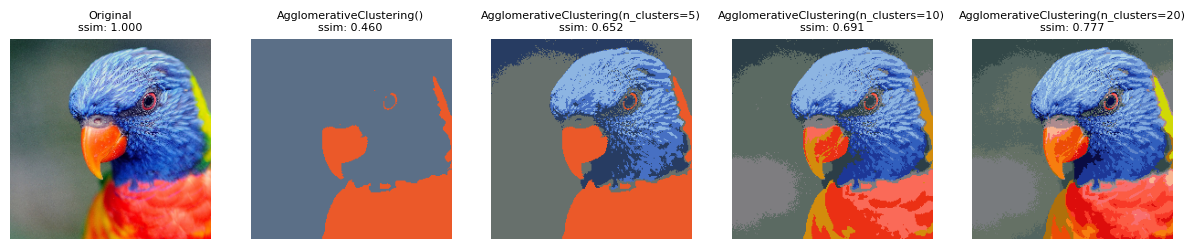

AgglomerativeClustering длительность 521.68 сек


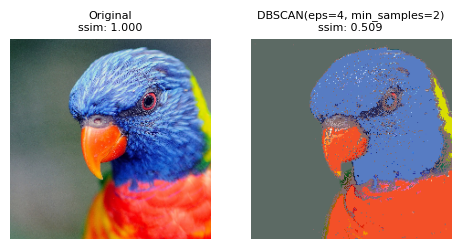

DBSCAN длительность 1.37 сек


In [12]:
#1 график
start_time = time.time()
fig = plt.figure(figsize=(15,15))
for i, n_clusters in enumerate(K):
    fig.add_subplot(1, 5, i+1)
    get_image(img, KMeans, n_clusters=n_clusters)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()
print("KMeans длительность "+ str(round((time.time() - start_time), 2)) + " сек")
#2 график
start_time = time.time()
fig = plt.figure(figsize=(15,15))
for i, n_clusters in enumerate(K):
    fig.add_subplot(1, 5, i+1)
    get_image(img, AgglomerativeClustering, n_clusters=n_clusters)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()
print("AgglomerativeClustering длительность "+ str(round((time.time() - start_time), 2)) + " сек")
#3 график
start_time = time.time()
fig = plt.figure(figsize=(15,15))
for i, model in enumerate([None, DBSCAN]):
    fig.add_subplot(1, 5, i+1)
    get_image(img, model)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()
print("DBSCAN длительность "+ str(round((time.time() - start_time), 2)) + " сек")

__В результате:__  
1. Для поставленной задачи `KMeans` самый лучший вариант. 
2. У `AgglomerativeClustering` метрика несколько хуже. К тому же от него виснет процессор и им можно обрабатывать картинки размерностью не более __180 x 180__ либо существенно сжимать исходные.
3. У `DBSCAN` нет параметра выбора количества кластеров, он работает быстро, но создает много шума и по этому метрика самая низкая. Для картинок его лучше не использовать